In [21]:
import math
import numpy as np
import pandas as pd
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt
import json

from src.model import MockModel
from src.utils import index_for_arange, write_results, cq_labels, cq_filter
import src.plot as plot
from src.eval import (
    adjusted_classification_x_width_score,
    size_stratified_classification_coverage_score,
    cq_stats,
    set_size_equals,
)
from src.heuristics import TopKSelector, HeuristicCutoffSelector, TopKCutoffSelector

In [22]:
# load data
dataset = 'mtod'
intent_classifier = 'bert'
data_dir = f'data/{dataset}/{intent_classifier}/'

df_train_preds = pd.read_csv(data_dir + "train_predictions.csv")
df_test_preds = pd.read_csv(data_dir + "test_predictions.csv")
df_calibration_preds = pd.read_csv(data_dir + "calibration_predictions.csv")

labels = pd.read_csv(data_dir+'/labels.csv', header=0, names=['index','label'])
labels = list(labels.label.fillna('oos'))
N_INTENTS = len(labels)
N_INTENTS

12

In [23]:
# check train-calibration-test split sizes
df_train_preds.shape[0], df_calibration_preds.shape[0], df_test_preds.shape[0]

(25993, 8665, 8665)

In [24]:
# apply some basic transformations
df_train = df_train_preds.reset_index().rename(columns={'index': 'utterance'})
df_test = df_test_preds.reset_index().rename(columns={'index': 'utterance'})
df_calibration = df_calibration_preds.reset_index().rename(columns={'index': 'utterance'})

df_train['utterance'] = df_train['utterance'].apply(lambda h: 'train_' + str(h))
df_test['utterance'] = df_test['utterance'].apply(lambda h: 'test_' + str(h))
df_calibration['utterance'] = df_calibration['utterance'].apply(lambda h: 'cal_' + str(h))

df_train['utterance'] = df_train['utterance'].astype(str)
df_test['utterance'] = df_test['utterance'].astype(str)
df_calibration['utterance'] = df_calibration['utterance'].astype(str)

In [25]:
# merge datasets to single frame
fullset = pd.concat([df_train, df_test, df_calibration], ignore_index=True)
assert fullset.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset = fullset.drop(['label', 'hash', 'text'], axis=1)
fullset.head()

,utterance,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9,label_10,label_11
0,train_0,0.999007,0.000289,0.000035,0.000042,0.000010,0.000325,1.254541e-04,0.000019,0.000030,0.000019,0.000043,0.000055
1,train_1,0.000047,0.000003,0.000007,0.000011,0.000005,0.000099,9.997572e-01,0.000010,0.000019,0.000004,0.000033,0.000004
2,train_2,0.999133,0.000239,0.000034,0.000037,0.000011,0.000287,1.204069e-04,0.000021,0.000022,0.000020,0.000043,0.000033
3,train_3,0.000028,0.000003,0.000007,0.000012,0.000004,0.000061,9.998246e-01,0.000013,0.000020,0.000004,0.000020,0.000004
4,train_4,0.000002,0.000002,0.000002,0.000009,0.999970,0.000002,9.835709e-07,0.000003,0.000003,0.000003,0.000002,0.000001


In [26]:
# parameters for evaluation
X_train = fullset[['utterance']]
X_calib = df_calibration[['utterance']]
X_test = df_test[['utterance']]

a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 7

target_alpha = .01
target_index = index_for_arange(a_start, a_step ,target_alpha)

In [27]:
# instantiate a mock sklearn model which simply looks up the results in a lookup table
model = MockModel(fullset, 'utterance', softmax=False, classes=list(range(N_INTENTS)))
# fit the test dataset
model.fit(X_test, df_test['label'])
# extract the test targets from the datasets
y_test = df_test['label'].apply(lambda lbl: list(model.classes_).index(lbl))

In [28]:
y_test.min(), y_test.max()

(0, 11)

In [29]:
# marginal conformal prediction
mapie_marginal = MapieClassifier(estimator=model, cv="prefit", method="score", random_state=42)
mapie_marginal.fit(X_calib, df_calibration['label'])
y_pred_marginal, y_ps_marginal = mapie_marginal.predict(X_test, alpha=alpha)


coverages_marginal = [
    classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_marginal = [
    adjusted_classification_x_width_score(y_ps_marginal[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_marginal = [
    set_size_equals(y_ps_marginal[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_marginal = [
    (y_ps_marginal[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_marginal = [
    size_stratified_classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]

results = cq_stats(y_ps_marginal[:, :, target_index], y_test, max_ps_size)
write_results('mtod-bert-cicc', dataset, intent_classifier, 'cicc', results)
results

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)
/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9921523369878823, 0.9998845931909983, nan, 0.0)

In [30]:
# adaptive conformal prediction
mapie_adaptive = MapieClassifier(estimator=model, cv="prefit", method="cumulated_score", random_state=42)
mapie_adaptive.fit(X_calib, df_calibration['label'])
y_pred_adaptive, y_ps_adaptive = mapie_adaptive.predict(X_test, alpha=alpha)


coverages_adaptive = [
    classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_adaptive = [
    adjusted_classification_x_width_score(y_ps_adaptive[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_adaptive = [
    set_size_equals(y_ps_adaptive[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_adaptive = [
    (y_ps_adaptive[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_adaptive = [
    size_stratified_classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_adaptive[:, :, target_index], y_test, max_ps_size)

(0.9966532025389498, 0.9773802654356607, 2.357142857142857, 0.0)

In [31]:
# TOP-K conformal prediction
mapie_topk = MapieClassifier(estimator=model, cv="prefit", method="top_k", random_state=42)
mapie_topk.fit(X_calib, df_calibration['label'])
y_pred_topk, y_ps_topk = mapie_topk.predict(X_test, alpha=alpha)


coverages_topk = [
    classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_topk = [
    adjusted_classification_x_width_score(y_ps_topk[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_topk = [
    set_size_equals(y_ps_topk[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_topk = [
    (y_ps_topk[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_topk = [
    size_stratified_classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_topk[:, :, target_index], y_test, max_ps_size)

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)
/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9921523369878823, 1.0, nan, 0.0)

In [32]:
# RAPS
mapie_raps = MapieClassifier(estimator=model, cv="prefit", method="raps")
mapie_raps.fit(X_calib, df_calibration['label'])
y_pred_raps, y_ps_raps = mapie_raps.predict(X_test, alpha=alpha)


coverages_raps = [
    classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_raps = [
    adjusted_classification_x_width_score(y_ps_raps[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_raps = [
    set_size_equals(y_ps_raps[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_raps = [
    (y_ps_raps[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_raps = [
    size_stratified_classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_raps[:, :, target_index], y_test, max_ps_size)

(0.9971148297749567, 0.9564916330063473, 2.0, 0.0)

In [33]:
# heuristic 1: select all classes above a certain cutoff or the top-5 if there are none
topk_cutoff = TopKCutoffSelector(estimator=model, cutoff=1-target_alpha, k=5)
y_ps_h1 = topk_cutoff.predict(X_test)
results_h1 = cq_stats(y_ps_h1, y_test, max_ps_size)
write_results('mtod-bert-h1', dataset, intent_classifier, 'h1', results_h1)
results_h1

(0.9966532025389498, 0.9817657241777265, 5.0, 0.0)

In [34]:
top_95 = HeuristicCutoffSelector(estimator=model, cutoff=1-target_alpha)
y_ps_h2 = top_95.predict(X_test)
results_h2 = cq_stats(y_ps_h2, y_test, max_ps_size)
write_results('mtod-bert-h2', dataset, intent_classifier, 'h2', results_h2)
results_h2

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9921523369878823, 1.0, nan, 0.0)

In [35]:
topk_5 = TopKSelector(estimator=model, k=5)
y_ps_h3 = topk_5.predict(X_test)

results_h3 = cq_stats(y_ps_h3, y_test, max_ps_size)
write_results('mtod-bert-h3', dataset, intent_classifier, 'h3', results_h3)
results_h3

(0.9997691863819965, 0.0, 5.0, 0.0)

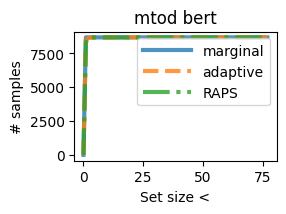

In [36]:
to_plot = [
    (y_ps_marginal, 'marginal', '-', None),
    (y_ps_adaptive, 'adaptive', '--', None),
    (y_ps_raps, 'RAPS', '-.', None),
    # (y_ps_topkmapie, 'TOPK', ':', None),
    # (y_ps_top_5_95, 'heuristic a', 'dashed', 'black'),
    # (y_ps_top_95,  'heuristic b', 'dotted', 'black'),
    # (y_ps_topk_5,  'heuristic c', '-.', 'black'),
]
fig, ax = plt.subplots(1, 1, figsize=plot.fig_dim_1)
for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    ax.plot(
        np.cumsum([set_size_equals(to_plot_result, i) for i in range(78)]),
        label=label,
        linestyle=style,
        color=color,
        linewidth=3,
        alpha=.8)
    # ax.set_xscale('log')
plt.xlabel('Set size <')
plt.ylabel('# samples')
plt.title(f'{dataset} {intent_classifier}'.format(target_alpha))
plt.legend(handlelength=3.5)
plt.tight_layout()
plt.savefig(f'results/cum_set_size_{dataset}_{intent_classifier}.png', dpi=1200)

In [37]:
y_ps_which = y_ps_marginal
ambiguous_indices = np.where((y_ps_which[:, :, target_index].sum(axis=1) >= 2))
ambiguous = df_test.loc[ambiguous_indices]
len(list(zip(ambiguous.index,[ labels[l] for l in ambiguous.label.tolist()], ambiguous.text.tolist())))

0

In [38]:
for a in ambiguous.index:
    alternatives = np.where(y_ps_which[a, :, target_index])[0]
    print(" & ".join([ambiguous.loc[a].text, labels[ambiguous.loc[a].label].replace("_", " "), ', '.join([labels[l].replace("_", " ") for l in alternatives])]) + " \\\\")

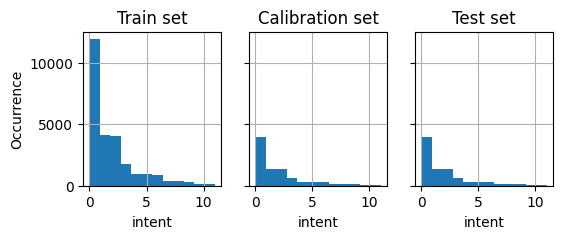

In [39]:
label_sorting_map = {i: x for x, i in enumerate(df_train.label.value_counts(sort=True).index)}
for i in range(len(labels)):
    if i not in label_sorting_map:
        label_sorting_map[i] = len(label_sorting_map)
fig, axs = plt.subplots(1,3,figsize=(plot.fig_width_in * 2, 2), sharey=True)
pd.Series(list(map(lambda x: label_sorting_map[x], df_train.label, ))).hist(bins=N_INTENTS, ax=axs[0])
pd.Series(list(map(lambda x: label_sorting_map[x], df_calibration.label, ))).hist(bins=N_INTENTS, ax=axs[1])
pd.Series(list(map(lambda x: label_sorting_map[x], df_test.label, ))).hist(bins=N_INTENTS, ax=axs[2])
titles = ['Train set', 'Calibration set', 'Test set']
[ax.set_xlabel('intent') for ax in axs]
[ax.set_title(title) for (ax, title) in zip(axs, titles)]
axs[0].set_ylabel('Occurrence')
# plt.yticks([]) 
plt.savefig(f"results/label_distribution_{dataset}.png", dpi=1200)
plt.show()

In [40]:
cq_inputs = df_test[cq_filter(y_ps_marginal[:, :, target_index], max_ps_size)].text
cq_lbls = cq_labels(y_ps_marginal[:, :, target_index], max_ps_size, labels)

cqs = []
for i, (text, lbls) in enumerate(zip(cq_inputs, cq_lbls)):
    cqs.append({
        "id": i,
        "text": text,
        "predictions": lbls,
    })

with open(f'results/clarification_questions_{dataset}_{intent_classifier}.json', 'w') as f:
    json.dump(cqs, f, indent=4)

In [61]:
pd.Series(np.cumsum([set_size_equals(y_ps_marginal[:, :, target_index], i) for i in range(N_INTENTS+1)])).to_csv(f'results/cum_{dataset}_{intent_classifier}.csv')

     ps_size  clinc150_bert
0          0       0.000000
1          1       0.966436
2          2       0.988072
3          3       0.994175
4          4       0.996117
..       ...            ...
147      147       1.000000
148      148       1.000000
149      149       1.000000
150      150       1.000000
151      151       1.000000

[152 rows x 2 columns]
     ps_size  clinc150_bert_ood
0          0           0.000000
1          1           0.708889
2          2           0.767222
3          3           0.813333
4          4           0.848333
..       ...                ...
147      147           1.000000
148      148           1.000000
149      149           1.000000
150      150           1.000000
151      151           1.000000

[152 rows x 2 columns]


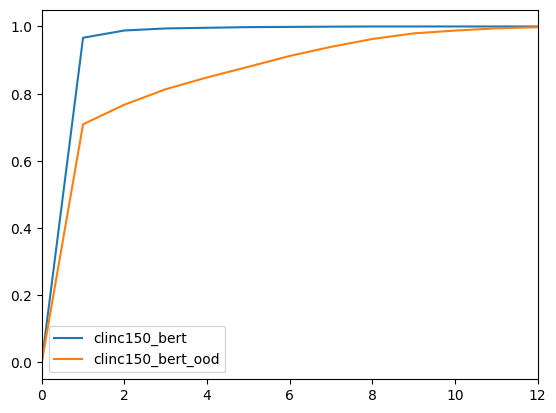

In [76]:
cumulative_size_files = [
    # 'acid_bert',
    # 'atis_bert',
    # 'banking77_dfcx',
    # 'banking77_bert',
    'clinc150_bert',
    'clinc150_bert_ood',
    # 'hwu64_bert',
    # 'mtod_bert',

]
cumulated_scores = pd.DataFrame()
results = []
for f in cumulative_size_files:
    result = pd.read_csv(f"results/cum_{f}.csv", names=['ps_size', f], header=0)
    # result['ps_size'] = result['ps_size'] / result['ps_size'].max()
    result[f] = result[f] / result[f].max()
    plt.plot(result['ps_size'], result[f], label=f)
    print(result)
plt.xlim((0,12))
plt.legend()
plt.show()
